In [5]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from tune_sklearn import TuneSearchCV
from sklearn.tree import DecisionTreeClassifier
import numpy as np

In [6]:
x, y = load_breast_cancer(return_X_y=True)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

In [31]:
def tuning(learners, local_ds, theta):
    global_predictions = []
    global_dist = []
    for learner in learners:
        global_predictions.append(learner.predict(global_set_x))
    global_predictions = np.array(global_predictions)
    
    certain_global_x = []
    certain_global_predictions = []
    correct_count = 0
    for i in range(len(global_set_x)):
        tmp = np.zeros(n_classes)
        for ind, pred in enumerate(global_predictions[:, i]):
            tmp[pred] += 1
        if tmp.max() >= theta:
            certain_global_x.append(global_set_x[i])
            certain_global_predictions.append(np.argmax(tmp))
            if np.argmax(tmp) == global_set_y[i]:
                correct_count += 1
    #print("Certain predictions amount", len(certain_global_predictions), "with correct in them", correct_count)
    
    learners = []
    acc = 0
    for i in range(n_learners):
        clf = DecisionTreeClassifier()
        if len(certain_global_x) > 0:
            local_X = np.vstack([local_set_x[i*local_ds:(i+1)*local_ds], certain_global_x])
            local_Y = np.hstack([local_set_y[i*local_ds:(i+1)*local_ds], certain_global_predictions])
        else:
            local_X = local_set_x[i*local_ds:(i+1)*local_ds]
            local_Y = local_set_y[i*local_ds:(i+1)*local_ds]
        clf.fit(local_X, local_Y)
        acc += clf.score(x_test, y_test)
        learners.append(clf)
    #print("Average accuracy of local workers", acc/n_learners)
        
    return learners, acc/len(learners)

In [22]:
print("Data size", len(x_train))
n_classes = len(np.unique(y_train))
print("classes", n_classes)

Data size 426
classes 2


In [23]:
# unlabeled examples
m = 300
global_set_x = x_train[:m]
global_set_y = y_train[:m]
# labeled examples
local_set_x = x_train[m:]
local_set_y = y_train[m:]
n = len(x_train) - m
n_learners = 5
theta = 4
local_ds = n//n_learners
print("Length of the local dataset", local_ds)

Length of the local dataset 25


In [28]:
learners = []
acc = 0
for i in range(n_learners):
    clf = DecisionTreeClassifier()
    local_X = local_set_x[i*local_ds:(i+1)*local_ds]
    local_Y = local_set_y[i*local_ds:(i+1)*local_ds]
    #print(Counter(local_Y))
    clf.fit(local_X, local_Y)
    acc += clf.score(x_test, y_test)
    learners.append(clf)
print("Average accuracy of local workers", acc/n_learners)

Average accuracy of local workers 0.8965034965034965


In [29]:
for i in range(20):
    learners, acc = tuning(learners, local_ds, theta)
    print(acc)

Certain predictions amount 276 with correct in them 262
0.8965034965034965
Certain predictions amount 298 with correct in them 270
0.9006993006993007
Certain predictions amount 299 with correct in them 270
0.902097902097902
Certain predictions amount 299 with correct in them 270
0.8993006993006993
Certain predictions amount 300 with correct in them 270
0.9006993006993007
Certain predictions amount 300 with correct in them 270
0.9034965034965035
Certain predictions amount 300 with correct in them 270
0.8993006993006993
Certain predictions amount 300 with correct in them 270
0.902097902097902
Certain predictions amount 300 with correct in them 270
0.8993006993006993
Certain predictions amount 300 with correct in them 270
0.9034965034965035
Certain predictions amount 300 with correct in them 270
0.9006993006993007
Certain predictions amount 300 with correct in them 270
0.9006993006993007
Certain predictions amount 300 with correct in them 270
0.8993006993006993
Certain predictions amount 

### Random runs

In [32]:
accs = []
for i in range(50):
    learners = []
    accs.append([])
    acc = 0
    for i in range(n_learners):
        clf = DecisionTreeClassifier()
        local_X = local_set_x[i*local_ds:(i+1)*local_ds]
        local_Y = local_set_y[i*local_ds:(i+1)*local_ds]
        #print(Counter(local_Y))
        clf.fit(local_X, local_Y)
        acc += clf.score(x_test, y_test)
        learners.append(clf)
    accs[-1].append(acc/n_learners)
    for i in range(20):
        learners, acc = tuning(learners, local_ds, theta)
        accs[-1].append(acc)

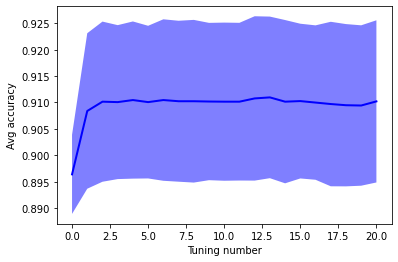

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

mu = np.array(accs).mean(axis=0)
sigma = np.array(accs).std(axis=0)

plt.plot(range(21), mu, lw=2, label='mean', color='blue')
plt.fill_between(range(21), mu+sigma, mu-sigma, facecolor='blue', alpha=0.5)

plt.ylabel("Avg accuracy")
plt.xlabel("Tuning number")
plt.show()